# Final Tsetlin Machine Pipine:

### Installing The TsetlinMachine Model:

In [2]:
!pip install pyTsetlinMachine
!pip install split-folders

  Preparing metadata (setup.py) ... done
  Created wheel for pyTsetlinMachine: filename=pyTsetlinMachine-0.6.6-cp310-cp310-linux_x86_64.whl size=59494 sha256=d93a50f6b15cafb367b2e32526781a45fb4f01a4cda18fc2e961d4820ea862a4
  Stored in directory: /root/.cache/pip/wheels/b0/b0/c5/07c4cb8bb93c5325bdc2c2a070b565f54df717d5d11f0c6802
Successfully built pyTsetlinMachine


### Importing libraries:

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import cv2
import splitfolders
# For Tsetlin Machine
from pyTsetlinMachine.tm import MultiClassTsetlinMachine
from pyTsetlinMachine.tm import MultiClassConvolutionalTsetlinMachine2D
import zipfile
from time import time


### Mount the Google Drive:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preparation

In [5]:
# Path of your dataset in Google Drive
data_dir = '/content/drive/My Drive/data'
output_dir = '/content/dataset'

# Split the dataset into train, validation, and test sets
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None)

# Define transformations for training and testing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(os.path.join(output_dir, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(output_dir, 'val'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(output_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Copying files: 752 files [00:15, 49.92 files/s]


In [6]:
#Number of Classes
num_classes = len(train_data.classes)

### Exloratory Data Analysis

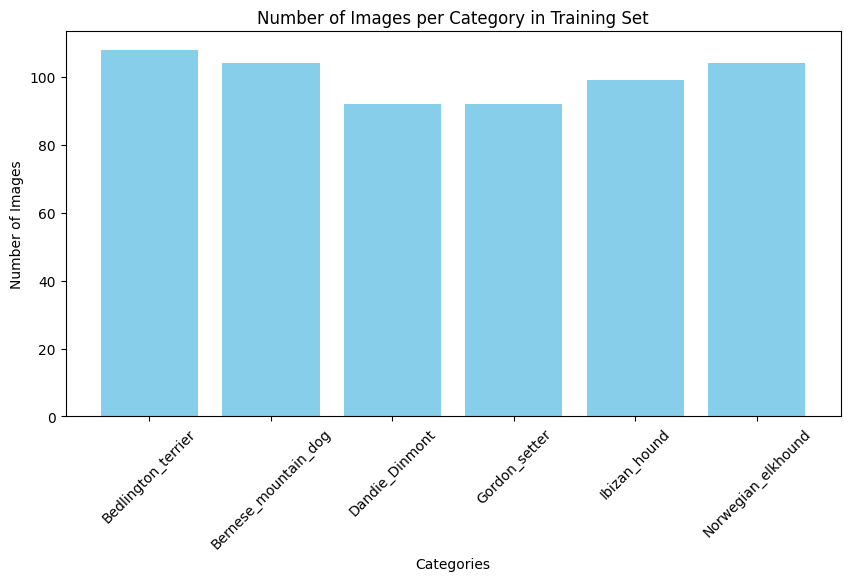

In [7]:
# Get the class names and number of images in each class
class_names = train_data.classes
class_counts = [0] * num_classes

for _, label in train_data:
    class_counts[label] += 1

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Training Set')
plt.xticks(rotation=45)
plt.show()

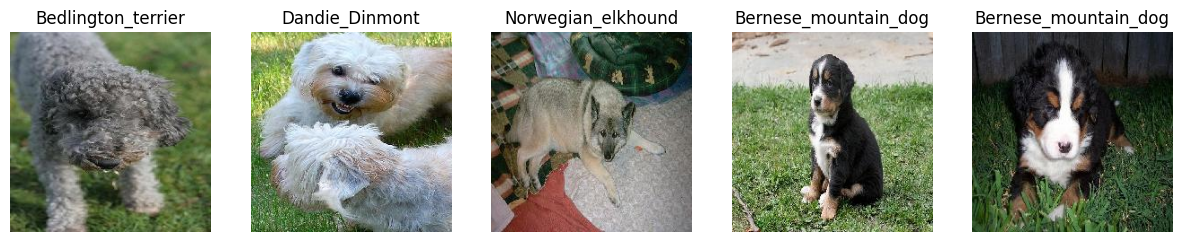

In [9]:
def show_random_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()

# Display random images from training dataset
show_random_images(train_data)

### Model Definition

In [17]:
# Model Definition
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')
    print('Finished Training')

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    print(classification_report(y_true, y_pred, target_names=test_data.classes))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.show()

# Hyperparameter Tuning and Training
def hyperparameter_tuning_and_training(model, train_loader, test_loader, criterion, learning_rates, num_epochs):
    for lr in learning_rates:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        print(f"Training with learning rate: {lr}")
        train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
        print("Evaluation on Test Set:")
        evaluate_model(model, test_loader)

### VGG-16 Model

Evaluation of VGG-16 Model
Training with learning rate: 0.001
Epoch [1/5], Loss: 0.7722
Epoch [2/5], Loss: 0.0412
Epoch [3/5], Loss: 0.0094
Epoch [4/5], Loss: 0.0023
Epoch [5/5], Loss: 0.0014
Finished Training
Evaluation on Test Set:
                      precision    recall  f1-score   support

  Bedlington_terrier       1.00      1.00      1.00        15
Bernese_mountain_dog       1.00      1.00      1.00        14
      Dandie_Dinmont       1.00      1.00      1.00        12
       Gordon_setter       1.00      1.00      1.00        13
        Ibizan_hound       1.00      1.00      1.00        13
  Norwegian_elkhound       1.00      1.00      1.00        13

            accuracy                           1.00        80
           macro avg       1.00      1.00      1.00        80
        weighted avg       1.00      1.00      1.00        80



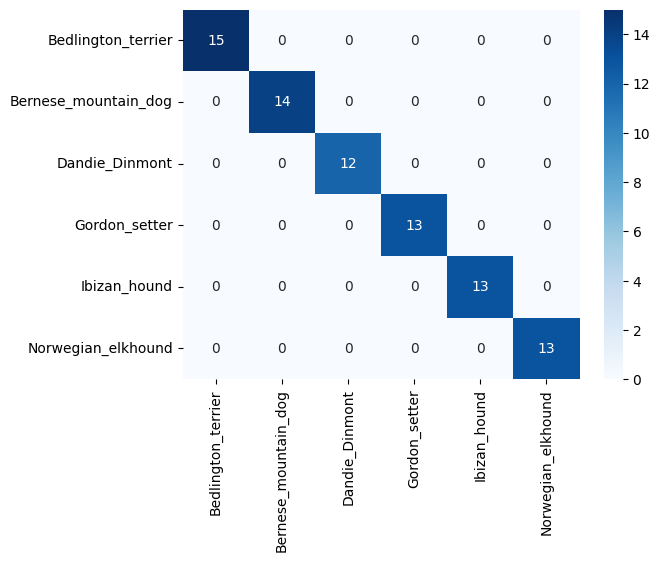

Training with learning rate: 0.0005
Epoch [1/5], Loss: 0.0008
Epoch [2/5], Loss: 0.0007
Epoch [3/5], Loss: 0.0008
Epoch [4/5], Loss: 0.0007
Epoch [5/5], Loss: 0.0004
Finished Training
Evaluation on Test Set:
                      precision    recall  f1-score   support

  Bedlington_terrier       1.00      1.00      1.00        15
Bernese_mountain_dog       1.00      1.00      1.00        14
      Dandie_Dinmont       1.00      1.00      1.00        12
       Gordon_setter       1.00      1.00      1.00        13
        Ibizan_hound       1.00      1.00      1.00        13
  Norwegian_elkhound       1.00      1.00      1.00        13

            accuracy                           1.00        80
           macro avg       1.00      1.00      1.00        80
        weighted avg       1.00      1.00      1.00        80



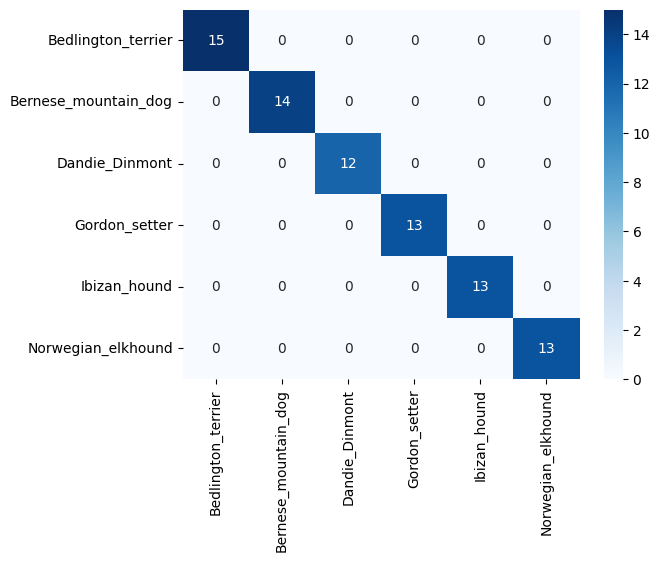

In [18]:
# VGG-16
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
criterion = nn.CrossEntropyLoss()
learning_rates = [0.001, 0.0005]
num_epochs = 5

print("Evaluation of VGG-16 Model")
hyperparameter_tuning_and_training(vgg16, train_loader, test_loader, criterion, learning_rates, num_epochs)

### ResNet Model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluation of ResNet Model
Training with learning rate: 0.001
Epoch [1/5], Loss: 1.2460
Epoch [2/5], Loss: 0.2622
Epoch [3/5], Loss: 0.1035
Epoch [4/5], Loss: 0.0669
Epoch [5/5], Loss: 0.0473
Finished Training
Evaluation on Test Set:
                      precision    recall  f1-score   support

  Bedlington_terrier       0.93      0.93      0.93        15
Bernese_mountain_dog       1.00      1.00      1.00        14
      Dandie_Dinmont       1.00      0.92      0.96        12
       Gordon_setter       1.00      1.00      1.00        13
        Ibizan_hound       0.93      1.00      0.96        13
  Norwegian_elkhound       1.00      1.00      1.00        13

            accuracy                           0.97        80
           macro avg       0.98      0.97      0.98        80
        weighted avg       0.98      0.97      0.97        80



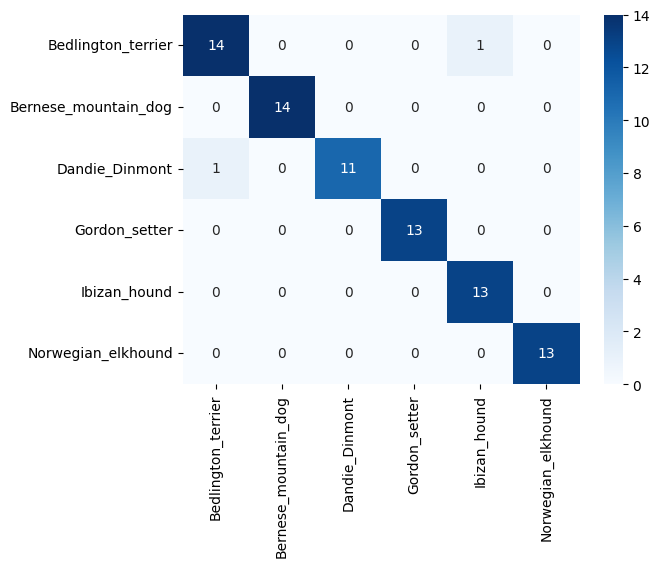

Training with learning rate: 0.0005
Epoch [1/5], Loss: 0.0403
Epoch [2/5], Loss: 0.0342
Epoch [3/5], Loss: 0.0325
Epoch [4/5], Loss: 0.0307
Epoch [5/5], Loss: 0.0357
Finished Training
Evaluation on Test Set:
                      precision    recall  f1-score   support

  Bedlington_terrier       0.93      0.93      0.93        15
Bernese_mountain_dog       1.00      1.00      1.00        14
      Dandie_Dinmont       1.00      0.92      0.96        12
       Gordon_setter       1.00      1.00      1.00        13
        Ibizan_hound       0.93      1.00      0.96        13
  Norwegian_elkhound       1.00      1.00      1.00        13

            accuracy                           0.97        80
           macro avg       0.98      0.97      0.98        80
        weighted avg       0.98      0.97      0.97        80



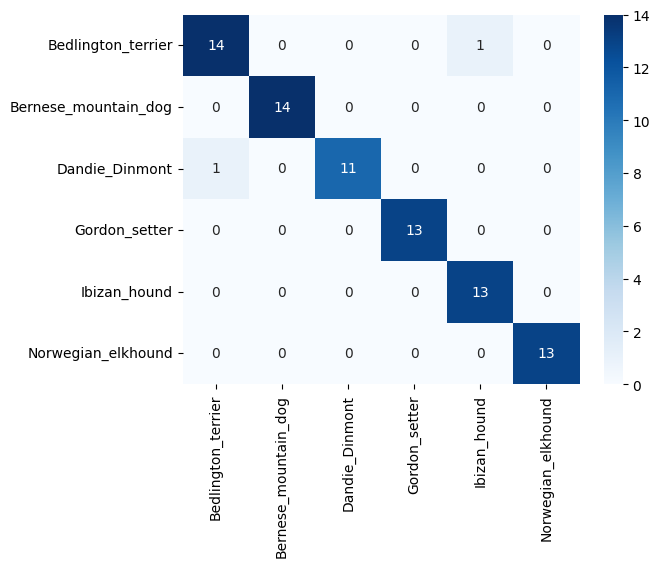

In [19]:
# ResNet
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
learning_rates = [0.001, 0.0005]
num_epochs = 5

print("Evaluation of ResNet Model")
hyperparameter_tuning_and_training(resnet, train_loader, test_loader, criterion, learning_rates, num_epochs)

### Custom CNN Model

Evaluation of Custom CNN Model
Training with learning rate: 0.001
Epoch [1/20], Loss: 1.7815
Epoch [2/20], Loss: 1.7108
Epoch [3/20], Loss: 1.6096
Epoch [4/20], Loss: 1.5003
Epoch [5/20], Loss: 1.4190
Epoch [6/20], Loss: 1.3543
Epoch [7/20], Loss: 1.2849
Epoch [8/20], Loss: 1.2512
Epoch [9/20], Loss: 1.2083
Epoch [10/20], Loss: 1.1765
Epoch [11/20], Loss: 1.2553
Epoch [12/20], Loss: 1.1599
Epoch [13/20], Loss: 1.0837
Epoch [14/20], Loss: 1.0572
Epoch [15/20], Loss: 0.9944
Epoch [16/20], Loss: 1.0155
Epoch [17/20], Loss: 0.9637
Epoch [18/20], Loss: 0.9625
Epoch [19/20], Loss: 0.9052
Epoch [20/20], Loss: 0.8631
Finished Training
Evaluation on Test Set:
                      precision    recall  f1-score   support

  Bedlington_terrier       0.27      0.27      0.27        15
Bernese_mountain_dog       0.83      0.36      0.50        14
      Dandie_Dinmont       0.33      0.58      0.42        12
       Gordon_setter       0.54      0.54      0.54        13
        Ibizan_hound       0.0

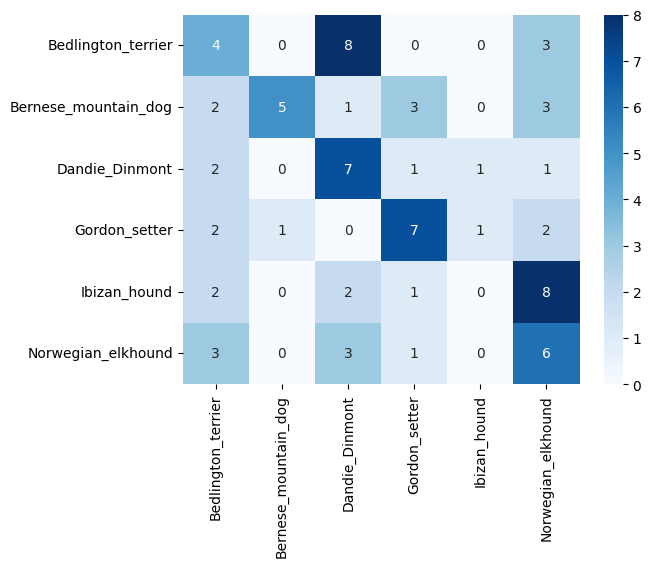

Training with learning rate: 0.0005
Epoch [1/20], Loss: 0.7587
Epoch [2/20], Loss: 0.7167
Epoch [3/20], Loss: 0.6780
Epoch [4/20], Loss: 0.6362
Epoch [5/20], Loss: 0.6059
Epoch [6/20], Loss: 0.5448
Epoch [7/20], Loss: 0.5931
Epoch [8/20], Loss: 0.5284
Epoch [9/20], Loss: 0.6386
Epoch [10/20], Loss: 0.5518
Epoch [11/20], Loss: 0.4722
Epoch [12/20], Loss: 0.4487
Epoch [13/20], Loss: 0.4541
Epoch [14/20], Loss: 0.4243
Epoch [15/20], Loss: 0.3810
Epoch [16/20], Loss: 0.3836
Epoch [17/20], Loss: 0.3372
Epoch [18/20], Loss: 0.3098
Epoch [19/20], Loss: 0.2840
Epoch [20/20], Loss: 0.2107
Finished Training
Evaluation on Test Set:
                      precision    recall  f1-score   support

  Bedlington_terrier       0.50      0.13      0.21        15
Bernese_mountain_dog       0.62      0.36      0.45        14
      Dandie_Dinmont       0.35      0.58      0.44        12
       Gordon_setter       0.45      0.69      0.55        13
        Ibizan_hound       0.43      0.23      0.30        1

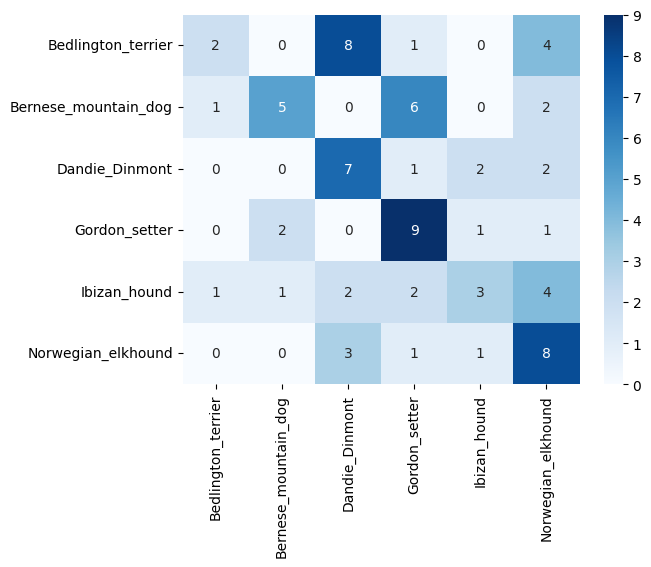

In [20]:
# Model Definition
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')
    print('Finished Training')

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    print(classification_report(y_true, y_pred, target_names=test_data.classes))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.show()

# Hyperparameter Tuning and Training
def hyperparameter_tuning_and_training(model, train_loader, test_loader, criterion, learning_rates, num_epochs):
    for lr in learning_rates:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        print(f"Training with learning rate: {lr}")
        train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
        print("Evaluation on Test Set:")
        evaluate_model(model, test_loader)

# Custom CNN
cnn = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
learning_rates = [0.001, 0.0005]
num_epochs = 20

print("Evaluation of Custom CNN Model")
hyperparameter_tuning_and_training(cnn, train_loader, test_loader, criterion, learning_rates, num_epochs)

### Tsetlin Machine Model

In [11]:
# Function to preprocess and convert images to binary
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    _, img_bin = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
    return img_bin

def load_data_as_binary(data_dir):
    X = []
    y = []
    class_names = []
    for class_idx, class_dir in enumerate(sorted(os.listdir(data_dir))):
        class_path = os.path.join(data_dir, class_dir)
        class_names.append(class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img_bin = preprocess_image(img_path)
                X.append(img_bin)
                y.append(class_idx)
    return np.array(X), np.array(y), class_names

# Convert images to binary format
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

X_train_bin, y_train_bin, class_names = load_data_as_binary(train_dir)
X_val_bin, y_val_bin, _ = load_data_as_binary(val_dir)
X_test_bin, y_test_bin, _ = load_data_as_binary(test_dir)

# Reshape data to add the channel dimension
X_train_bin = X_train_bin.reshape((X_train_bin.shape[0], 28, 28, 1))
X_val_bin = X_val_bin.reshape((X_val_bin.shape[0], 28, 28, 1))
X_test_bin = X_test_bin.reshape((X_test_bin.shape[0], 28, 28, 1))

#### Evaluation of Tsetlin Machine Model


Accuracy over 30 epochs:

#1 Accuracy: 36.99% (26.73s)
#2 Accuracy: 39.73% (20.30s)
Evaluation of Tsetlin Machine Model
                      precision    recall  f1-score   support

  Bedlington_terrier       0.60      0.40      0.48        15
Bernese_mountain_dog       0.43      0.43      0.43        14
      Dandie_Dinmont       0.47      0.58      0.52        12
       Gordon_setter       0.53      0.69      0.60        13
        Ibizan_hound       0.25      0.31      0.28        13
  Norwegian_elkhound       0.50      0.31      0.38        13

            accuracy                           0.45        80
           macro avg       0.46      0.45      0.45        80
        weighted avg       0.47      0.45      0.45        80



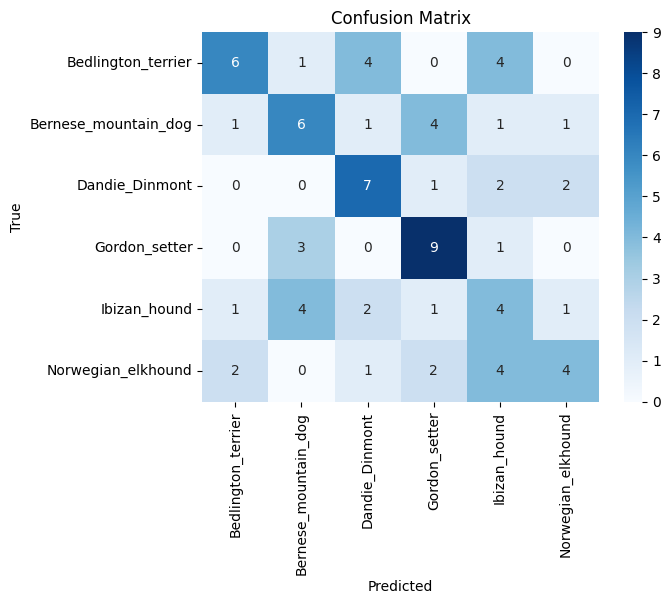

In [21]:
# Initialize the MultiClassConvolutionalTsetlinMachine2D model
# tm = MultiClassConvolutionalTsetlinMachine2D(5000, 30*100, 5.0, (5, 5), weighted_clauses=True)

print("\nAccuracy over 30 epochs:\n")
for i in range(2):
    start = time()
    tm.fit(X_train_bin, y_train_bin, epochs=1, incremental=True)
    stop = time()

    accuracy = 100*(tm.predict(X_val_bin) == y_val_bin).mean()
    print("#%d Accuracy: %.2f%% (%.2fs)" % (i+1, accuracy, stop-start))


# # Predict on the test set
y_pred_bin = tm.predict(X_test_bin)

# # Print evaluation report
print("Evaluation of Tsetlin Machine Model")
print(classification_report(y_test_bin, y_pred_bin, target_names=class_names))

# Print and plot confusion matrix
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Initialize the MultiClassConvolutionalTsetlinMachine2D model
tm = MultiClassConvolutionalTsetlinMachine2D(5000, 30*100, 5.0, (5, 5), weighted_clauses=True)

print("\nAccuracy over 30 epochs:\n")
for i in range(30):
    start = time()
    tm.fit(X_train_bin, y_train_bin, epochs=1, incremental=True)
    stop = time()

    accuracy = 100*(tm.predict(X_val_bin) == y_val_bin).mean()
    print("#%d Accuracy: %.2f%% (%.2fs)" % (i+1, accuracy, stop-start))


Accuracy over 30 epochs:

#1 Accuracy: 27.40% (17.09s)
#2 Accuracy: 31.51% (19.47s)
#3 Accuracy: 32.88% (19.63s)
#4 Accuracy: 35.62% (17.83s)
#5 Accuracy: 36.99% (19.18s)
#6 Accuracy: 35.62% (19.25s)
#7 Accuracy: 32.88% (19.82s)
#8 Accuracy: 36.99% (17.80s)
#9 Accuracy: 41.10% (17.83s)
#10 Accuracy: 35.62% (19.31s)
#11 Accuracy: 36.99% (17.76s)
#12 Accuracy: 41.10% (17.78s)
#13 Accuracy: 39.73% (19.59s)
#14 Accuracy: 39.73% (17.69s)
#15 Accuracy: 36.99% (17.69s)
#16 Accuracy: 39.73% (18.53s)
#17 Accuracy: 41.10% (19.88s)
#18 Accuracy: 43.84% (17.70s)
#19 Accuracy: 38.36% (18.93s)
#20 Accuracy: 34.25% (17.60s)
#21 Accuracy: 38.36% (17.64s)
#22 Accuracy: 35.62% (20.19s)
#23 Accuracy: 38.36% (19.34s)
#24 Accuracy: 43.84% (17.64s)
#25 Accuracy: 43.84% (17.58s)
#26 Accuracy: 41.10% (19.29s)
#27 Accuracy: 34.25% (19.82s)
#28 Accuracy: 39.73% (18.43s)
#29 Accuracy: 36.99% (17.71s)
#30 Accuracy: 41.10% (19.30s)
